# Predspracovanie údajov

Filip Mačina - 50% | Filip Remšík - 50%

In [1]:
import pandas as pd
import matplotlib as mat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler ,MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectFromModel
from pandas import read_csv
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
import category_encoders as ce
from sklearn.linear_model import LogisticRegression

# Načítanie dát a spojenie tabuliek

In [2]:
filename = "../1st-phase/056/stations.csv"
stations = pd.read_csv(filename, sep='\t')
filename = "../1st-phase/056/measurements.csv"
measurements = pd.read_csv(filename, sep='\t')

In [3]:
merged_data = pd.merge(stations, measurements, on=["longitude","latitude"])
merged_data.head()

,location,longitude,latitude,code,QoS,revision,PM10,PM2.5,NOx,H2CO,...,CH4,warning,Pb,NH3,CO,TEMP,PAHs,PRES,O3,CFCs
0,Europe/Madrid,-3.67029,37.13548,ES,excellent,"09/03/2019, 00:00:00",7.01439,7.66721,12.35004,37.29726,...,5.96890,0.0,42.65240,8.28526,2.78742,3.07926,12.55389,1124.98861,13.07032,55.88197
1,Europe/Madrid,-3.67029,37.13548,ES,excellent,"09/03/2019, 00:00:00",6.27482,7.11025,8.79628,46.30522,...,6.13067,0.0,34.60697,7.98489,9.92615,16.00714,5.94384,1085.03810,9.97918,51.10185
2,Europe/Madrid,-3.67029,37.13548,ES,excellent,"09/03/2019, 00:00:00",6.58617,9.81711,9.54310,70.85650,...,7.94460,0.0,50.79546,7.96687,10.56970,13.74220,8.19728,1166.06483,10.04280,50.68356
3,Europe/Madrid,-3.67029,37.13548,ES,excellent,"09/03/2019, 00:00:00",6.04616,7.19094,8.42786,27.22810,...,9.10165,1.0,54.71692,6.41596,8.98615,10.67437,6.27992,1180.46806,7.70173,52.05897
4,Europe/Madrid,-3.67029,37.13548,ES,excellent,"09/03/2019, 00:00:00",7.58300,7.39036,9.71392,53.85262,...,10.46966,0.0,55.95643,7.71467,7.84748,16.11613,9.69265,1194.32005,11.37336,79.96757


In [4]:
merged_data.describe()

,longitude,latitude,PM10,PM2.5,NOx,H2CO,C2H3NO5,SO2,CH4,warning,Pb,NH3,CO,TEMP,PAHs,PRES,O3,CFCs
count,25303.000000,25303.00000,25180.000000,25191.000000,25194.000000,25196.000000,25216.000000,25199.000000,25198.000000,25209.000000,25197.000000,25216.000000,25199.000000,25202.000000,25215.000000,25303.000000,25204.000000,25201.000000
mean,13.380134,31.35673,6.917030,8.220283,7.975746,50.706485,1.743878,8.214763,7.694474,0.592804,49.216538,8.215863,8.212756,14.916730,7.415887,1125.374114,8.722936,54.195827
std,70.955360,21.06379,1.306614,0.990617,1.876143,12.027588,2.755527,0.987261,1.855059,0.491322,13.203685,0.997356,1.877531,10.053450,1.793657,43.388899,1.643698,12.014682
min,-156.474320,-54.80000,1.686900,4.639680,1.376560,0.000000,0.000000,4.503160,2.021600,0.000000,0.000000,4.014580,1.849170,-24.474380,0.000000,1050.005850,3.794800,0.000000
25%,-48.592780,22.37066,6.096953,7.562260,6.612945,42.622485,0.813590,7.547220,6.400820,0.000000,40.233700,7.544250,6.820330,8.137230,6.183350,1088.326125,7.481425,45.983910
50%,13.321270,37.49073,6.923730,8.224610,7.797750,50.722540,1.125200,8.203930,7.519375,1.000000,49.092290,8.209050,8.315890,14.815880,7.260260,1124.908450,8.885485,54.228410
75%,72.344240,45.49428,7.760572,8.886760,9.293810,58.802770,1.723853,8.884515,8.849940,1.000000,58.047770,8.887120,9.595090,21.654542,8.493360,1163.322945,9.915535,62.262770
max,178.004170,68.79833,12.265880,12.089560,17.840410,100.000000,100.000000,11.899680,17.293770,1.000000,100.000000,12.470050,14.581490,54.542470,14.657650,1199.998520,15.494760,100.000000


Ako môžeme vidieť, po spojení dvoch datasetov nám počet záznamov v spojenom datasete stúpol. To nie je v poriadku.

***

# Integrácia a čistenie dát

Na to aby sme mohli aplikovať na naše datasety strojové učenie musíme si najskôr niektoré nečíselné hodnoty upraviť na číselné,
poprípade si upravíme ich tvar na jednotný. Niektoré dáta môžme odstrániť.

### Longitude & latitude

Tieto stĺpce nám slúžili na spojenie tabuliek, preto ich už teraz môžeme odstrániť.

In [5]:
merged_data=merged_data.drop(columns=['longitude','latitude'])

In [6]:
merged_data = merged_data.drop_duplicates(keep='first')

In [7]:
merged_data.describe()

,PM10,PM2.5,NOx,H2CO,C2H3NO5,SO2,CH4,warning,Pb,NH3,CO,TEMP,PAHs,PRES,O3,CFCs
count,24799.000000,24804.000000,24804.000000,24808.000000,24826.000000,24809.000000,24809.000000,24825.000000,24808.000000,24826.000000,24813.000000,24812.000000,24827.000000,24913.000000,24814.000000,24811.000000
mean,6.913775,8.219203,7.972537,50.753132,1.740296,8.218475,7.694874,0.591984,49.210044,8.216142,8.213669,14.907346,7.412335,1125.420468,8.721556,54.212061
std,1.307972,0.989279,1.875116,11.994579,2.744438,0.986724,1.858821,0.491476,13.215522,0.998458,1.876097,10.047291,1.793320,43.417014,1.645388,12.030384
min,1.686900,4.639680,1.376560,0.000000,0.000000,4.503160,2.021600,0.000000,0.000000,4.014580,1.849170,-24.474380,0.000000,1050.005850,3.794800,0.000000
25%,6.095650,7.560148,6.612710,42.703465,0.812130,7.554020,6.398350,0.000000,40.246280,7.543743,6.828240,8.136080,6.183350,1088.316110,7.474112,45.983910
50%,6.921630,8.223430,7.793030,50.769850,1.125130,8.209230,7.518190,1.000000,49.093195,8.204880,8.315890,14.813040,7.253570,1124.970850,8.883200,54.236140
75%,7.757320,8.884805,9.296750,58.827150,1.720773,8.886720,8.855770,1.000000,58.049777,8.889210,9.593780,21.648410,8.493360,1163.374250,9.916130,62.285130
max,12.265880,12.089560,17.840410,100.000000,100.000000,11.899680,17.293770,1.000000,100.000000,12.470050,14.581490,54.542470,14.657650,1199.998520,15.494760,100.000000


### QoS & Revision  & Code

Vzhľadom na to, že sme datasety *station* a *measurements* spájali podľa stĺcov 'longitude' a 'latitude', tak náš spojený dataset je viazaný na miesto stanice a nie na čas merania ani na kvalitu merania. To znamená, že tieto 2 atribúty nám duplikovali záznamy o kvalite ovzdušia, tým pádom sme sa rozhodli ich odstrániť.

In [8]:
merged_data=merged_data.drop(columns=['revision', 'QoS', 'code'])

In [9]:
merged_data = merged_data.drop_duplicates(keep='first')

In [10]:
merged_data.describe()

,PM10,PM2.5,NOx,H2CO,C2H3NO5,SO2,CH4,warning,Pb,NH3,CO,TEMP,PAHs,PRES,O3,CFCs
count,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11994.000000,11946.000000,11946.000000
mean,6.917451,8.213016,7.962936,50.799202,1.759448,8.212705,7.695716,0.595011,49.200288,8.217337,8.213436,14.963433,7.405901,1125.435995,8.723769,54.170817
std,1.316138,0.988466,1.871325,12.007618,2.906028,0.990948,1.868876,0.490910,13.279110,1.000247,1.880146,10.053632,1.790908,43.320439,1.651761,12.080563
min,1.686900,4.639680,1.376560,0.000000,0.000000,4.503160,2.021600,0.000000,0.000000,4.014580,1.849170,-24.474380,0.000000,1050.005850,3.794800,0.000000
25%,6.084235,7.551835,6.605915,42.630237,0.807693,7.545515,6.388802,0.000000,40.225678,7.548272,6.832190,8.208462,6.176897,1088.348817,7.466098,45.999837
50%,6.927625,8.221445,7.780315,50.786345,1.132460,8.204530,7.513125,1.000000,49.137630,8.214505,8.320175,14.920895,7.256215,1125.219295,8.881235,54.163240
75%,7.764415,8.875085,9.277783,58.825823,1.740062,8.884600,8.855002,1.000000,58.081420,8.883057,9.605957,21.727310,8.486630,1163.101688,9.918685,62.313080
max,12.265880,12.089560,17.840410,100.000000,100.000000,11.899680,17.293770,1.000000,100.000000,12.470050,14.581490,54.542470,14.657650,1199.998520,15.494760,100.000000


In [11]:
merged_data.head()

,location,PM10,PM2.5,NOx,H2CO,C2H3NO5,SO2,CH4,warning,Pb,NH3,CO,TEMP,PAHs,PRES,O3,CFCs
0,Europe/Madrid,7.01439,7.66721,12.35004,37.29726,1.30108,8.91316,5.96890,0.0,42.65240,8.28526,2.78742,3.07926,12.55389,1124.98861,13.07032,55.88197
1,Europe/Madrid,6.27482,7.11025,8.79628,46.30522,1.22105,8.07051,6.13067,0.0,34.60697,7.98489,9.92615,16.00714,5.94384,1085.03810,9.97918,51.10185
2,Europe/Madrid,6.58617,9.81711,9.54310,70.85650,1.08384,7.29705,7.94460,0.0,50.79546,7.96687,10.56970,13.74220,8.19728,1166.06483,10.04280,50.68356
3,Europe/Madrid,6.04616,7.19094,8.42786,27.22810,0.97552,8.09395,9.10165,1.0,54.71692,6.41596,8.98615,10.67437,6.27992,1180.46806,7.70173,52.05897
4,Europe/Madrid,7.58300,7.39036,9.71392,53.85262,1.36154,6.90018,10.46966,0.0,55.95643,7.71467,7.84748,16.11613,9.69265,1194.32005,11.37336,79.96757


Ako môžeme vidieť, množstvo záznamov sa nám po odstránení týchto atribútov výrazne znížilo. Týmto sme zaistili, že jedno pozorovanie je opísané jedným riadkom.

### Location

Atribút *Location* nie je číselná hodnota, tak si tento atribút mierne upravíme na unikátne časti sveta.

In [12]:
merged_data[['area', 'nation']] = merged_data['location'].str.split('/',1, expand=True)
merged_data=merged_data.drop(columns='location')
merged_data=merged_data.drop(columns='nation')

C:\Users\filip\AppData\Local\Temp\ipykernel_24484\795229932.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  merged_data[['area', 'nation']] = merged_data['location'].str.split('/',1, expand=True)


In [13]:
merged_data.columns.values

array(['PM10', 'PM2.5', 'NOx', 'H2CO', 'C2H3NO5', 'SO2', 'CH4', 'warning',
       'Pb', 'NH3', 'CO', 'TEMP', 'PAHs', 'PRES', 'O3', 'CFCs', 'area'],
      dtype=object)

In [14]:
merged_data = merged_data[['warning', 'PM10', 'PM2.5', 'NOx', 'H2CO', 'C2H3NO5', 'SO2',
       'CH4', 'Pb', 'NH3', 'CO', 'TEMP', 'PAHs', 'PRES', 'O3',
       'CFCs', 'area']]

In [15]:
merged_data['area'].unique()

array(['Europe', 'America', 'Asia', 'Pacific', 'Africa', 'Australia',
       'Indian'], dtype=object)

In [16]:
#merged_data.to_csv('merged_data1.csv')

# Chýbajúce hodnoty

In [17]:
merged_data.isnull().sum()

warning    48
PM10       48
PM2.5      48
NOx        48
H2CO       48
C2H3NO5    48
SO2        48
CH4        48
Pb         48
NH3        48
CO         48
TEMP       48
PAHs       48
PRES        0
O3         48
CFCs       48
area        0
dtype: int64

In [18]:
correlation = merged_data.corr()
#correlation

C:\Users\filip\AppData\Local\Temp\ipykernel_24484\3436217334.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged_data.corr()


<AxesSubplot: >

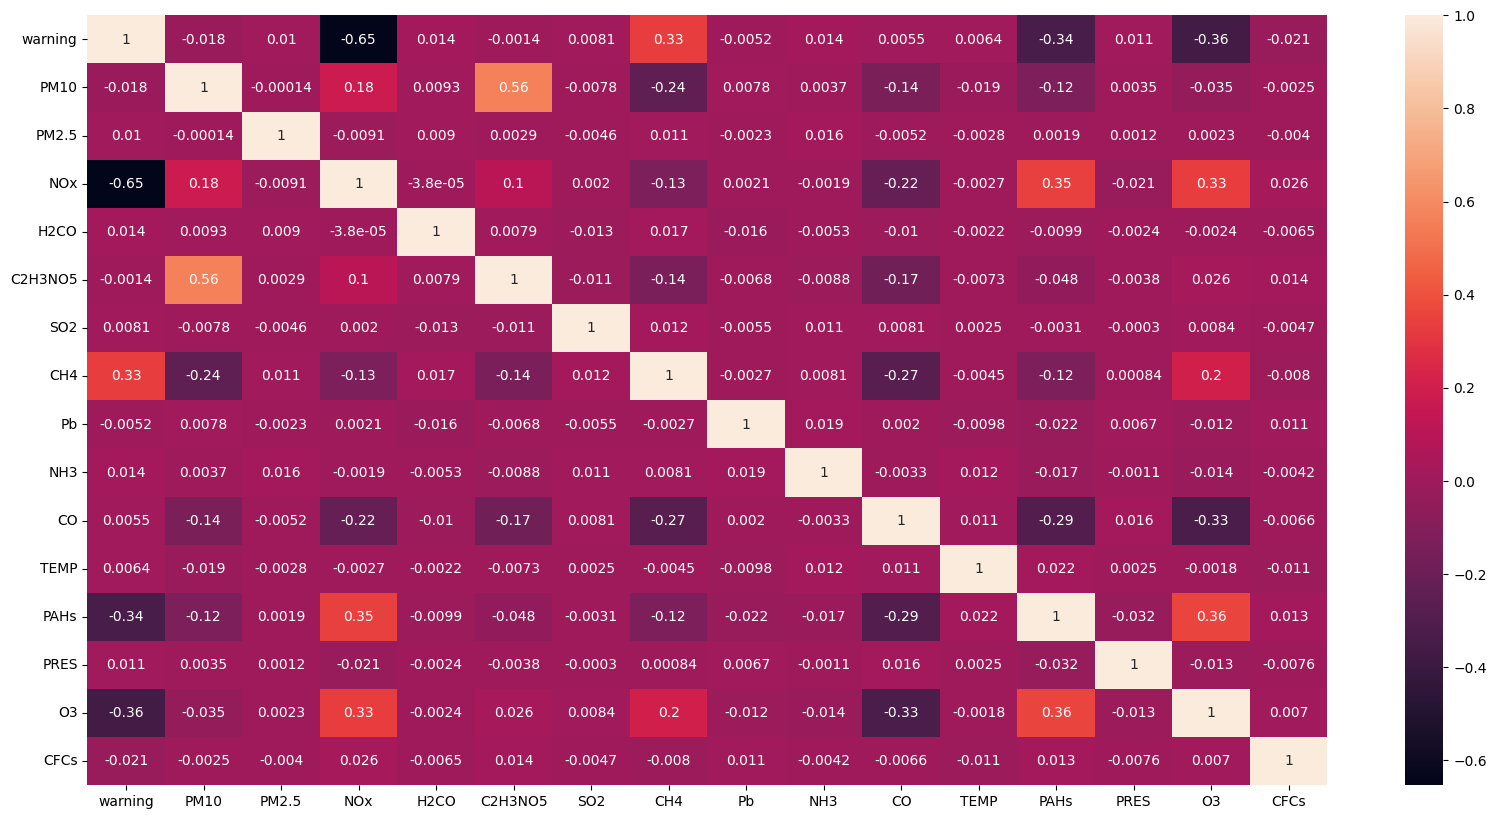

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True)

## Zmazanie chýbajúcich údajov

In [20]:
copy_data=merged_data.copy()
merged_data=merged_data.dropna()

C:\Users\filip\AppData\Local\Temp\ipykernel_24484\1862918223.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True)


<AxesSubplot: >

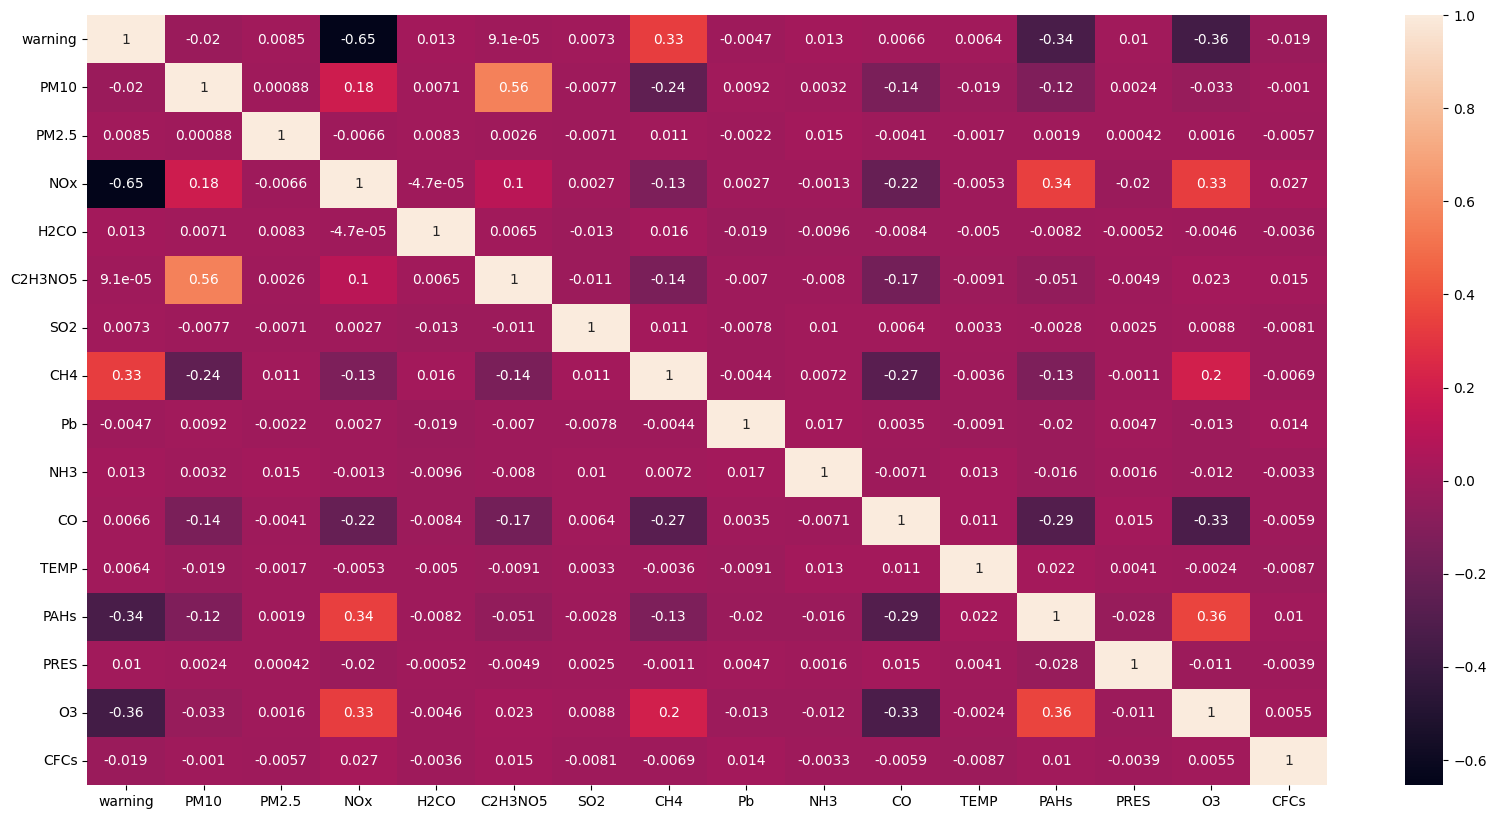

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(merged_data.corr(), annot=True)

## Nahradenie priemerom

In [22]:
merged_data=copy_data.copy()
for column in merged_data:
    if(merged_data[column].isnull().sum()!=0):
        mean_value=merged_data[column].mean()
        merged_data[column]=merged_data[column].fillna(mean_value)


C:\Users\filip\AppData\Local\Temp\ipykernel_24484\1862918223.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True)


<AxesSubplot: >

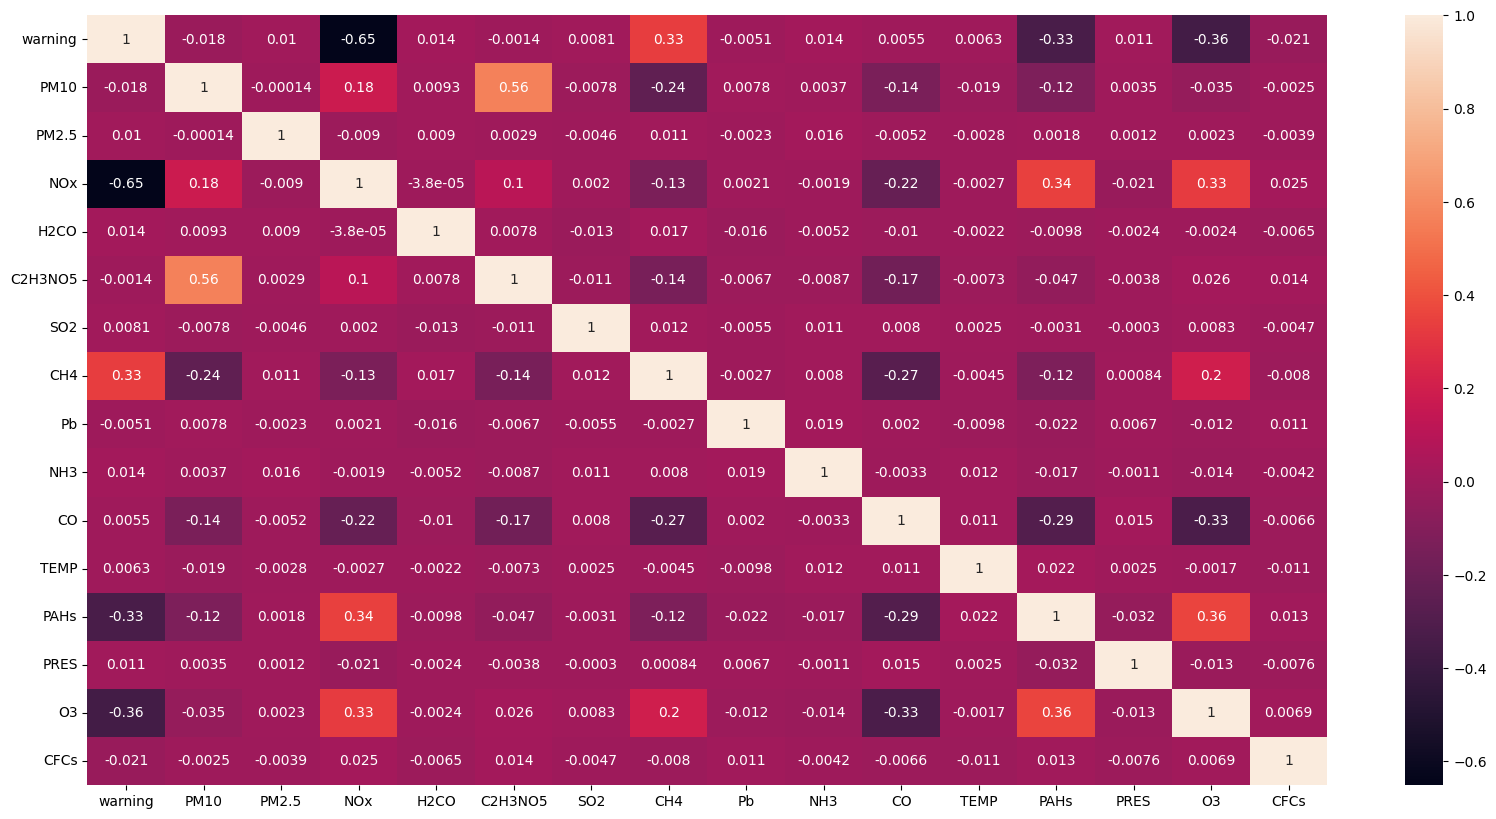

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(merged_data.corr(), annot=True)

## Nahradenie mediánom

In [24]:
merged_data=copy_data.copy()
for column in merged_data:
    if(merged_data[column].isnull().sum()!=0):
        median_value=merged_data[column].median()
        merged_data[column]=merged_data[column].fillna(median_value)

    

C:\Users\filip\AppData\Local\Temp\ipykernel_24484\1862918223.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_data.corr(), annot=True)


<AxesSubplot: >

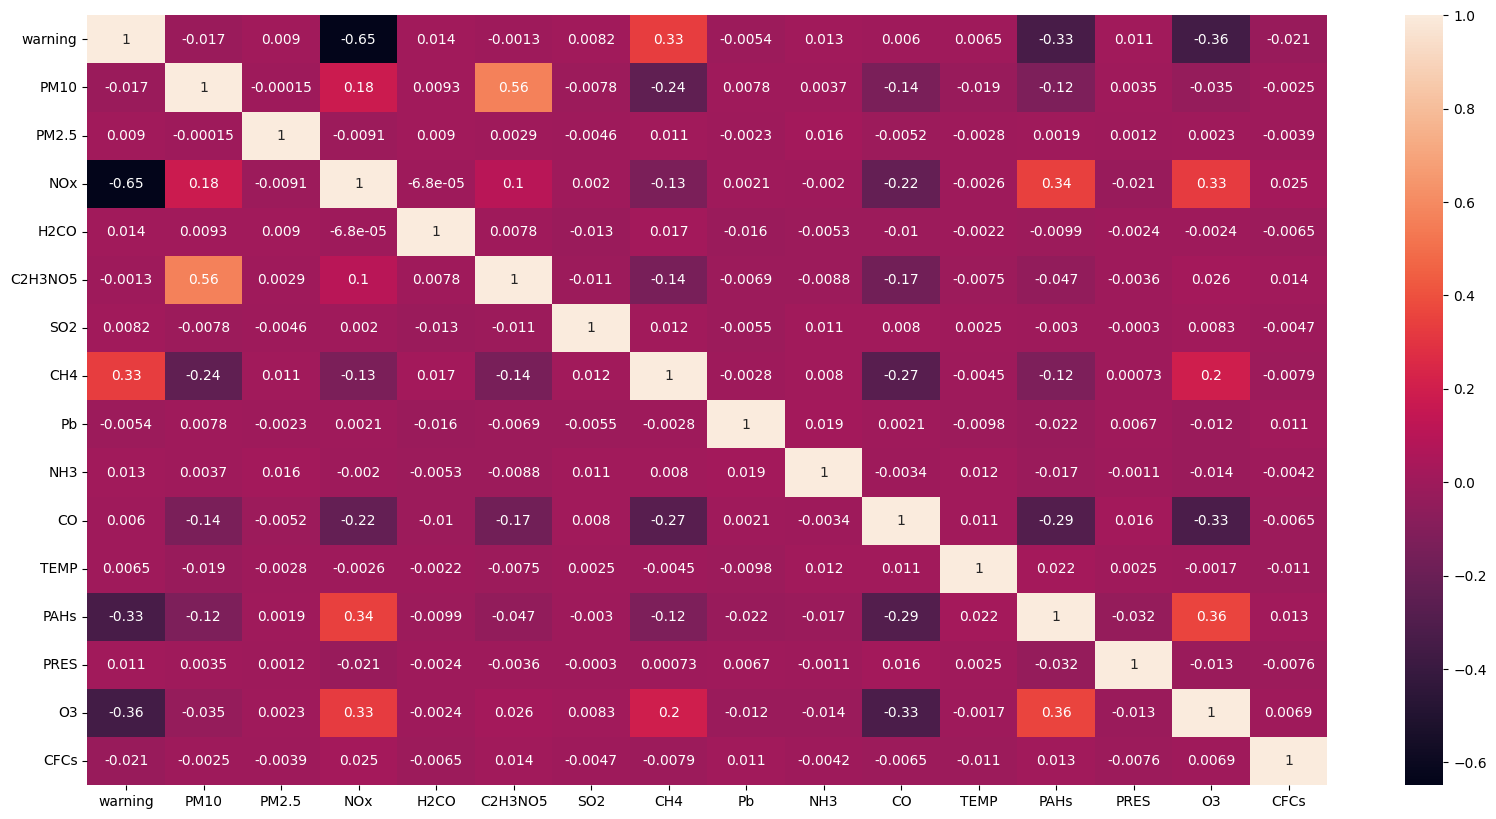

In [25]:
plt.figure(figsize=(20,10))
sns.heatmap(merged_data.corr(), annot=True)

Môžeme vidieť, že použitím metód s mediánom a priemerom sa nám takmer nezmenili kerelácie oproti neupraveným údajom, narozdiel od metódy zmazania prázdnych buniek.

# Vychýlené hodnoty

V 1. fáze projektu sme zistili, že stĺpec 'PRES' nemá žiadnych outlierov. Preto vizuálne porovnanie robíme bez tohoto stĺpca.

<AxesSubplot: >

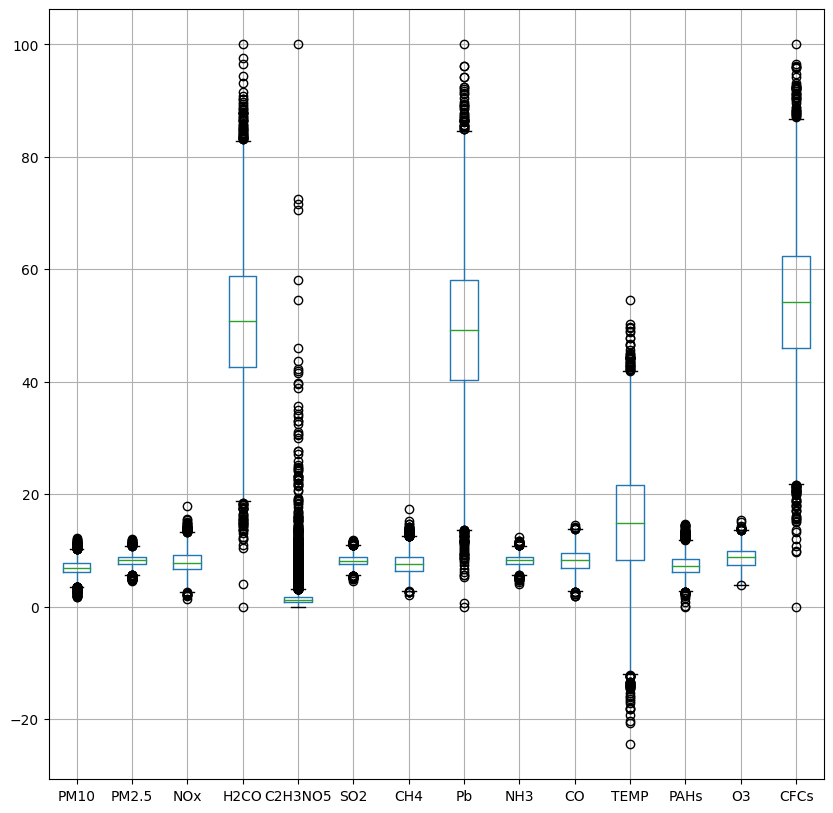

In [26]:
merged_data[['PM10', 'PM2.5', 'NOx', 'H2CO', 'C2H3NO5', 'SO2',
       'CH4', 'Pb', 'NH3', 'CO', 'TEMP', 'PAHs', 'O3',
       'CFCs']].boxplot(figsize=(10,10))

### Vymazanie vychýlených hodnôt (z prvej fázy projektu)

In [27]:
# funkcia na identifikovanie outliers
def identify_outliers(a):
        lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
        upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
        return a[(a > upper) | (a < lower)]

In [28]:
data_columns = merged_data.columns.values
print("All columns: ", data_columns)
# columns where we indentify outliers
outlier_colums = data_columns[1:16]
print("Columns for outlier detection: ", outlier_colums)

All columns:  ['warning' 'PM10' 'PM2.5' 'NOx' 'H2CO' 'C2H3NO5' 'SO2' 'CH4' 'Pb' 'NH3'
 'CO' 'TEMP' 'PAHs' 'PRES' 'O3' 'CFCs' 'area']
Columns for outlier detection:  ['PM10' 'PM2.5' 'NOx' 'H2CO' 'C2H3NO5' 'SO2' 'CH4' 'Pb' 'NH3' 'CO' 'TEMP'
 'PAHs' 'PRES' 'O3' 'CFCs']


In [29]:
def delete_outliers(df, columns):
    c = 0
    for item in columns:
        col = df[item]
        #print(item)
        col = col.dropna()
        col_out = identify_outliers(col)
        #print("COUNT: ", col_out.count())
        c = c + col_out.count()
        measurements_dropped = df.drop(col_out.index)
        df = measurements_dropped
        
    print("Total COUNT:", c)    
    return df

In [30]:
merged_data_deleted_outliers = delete_outliers(merged_data, outlier_colums)

Total COUNT: 2108


In [31]:
print("Old: ", merged_data.shape)
print("New: ", merged_data_deleted_outliers.shape)

Old:  (11994, 17)
New:  (9886, 17)


<AxesSubplot: >

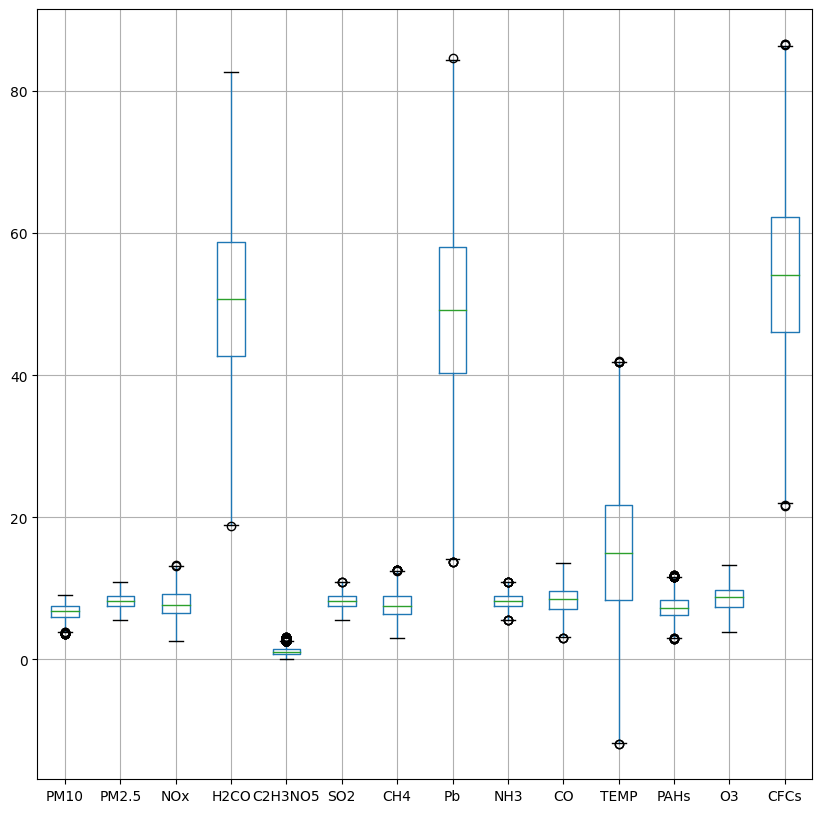

In [32]:
merged_data_deleted_outliers[['PM10', 'PM2.5', 'NOx', 'H2CO', 'C2H3NO5', 'SO2',
       'CH4', 'Pb', 'NH3', 'CO', 'TEMP', 'PAHs', 'O3',
       'CFCs']].boxplot(figsize=(10,10))

### Nahradenie vychýlených hodnôt hraničnými hodnotami rozdelenia

In [33]:
def replace_outliers(df, columns):
    for column in columns:
        #print("COLUMN: ", column)
        col = df[column]
        lower = col.quantile(0.25) - 1.5 * stats.iqr(col)
        #print("lower: ", lower)
        df[column] = np.where(df[column] < lower, lower , df[column])
        
        upper = col.quantile(0.75) + 1.5 * stats.iqr(col)
        #print("upper : ", upper)
        df[column] = np.where(df[column] > upper, upper , df[column])
        
    return df

In [34]:
replaced_outliers_data = replace_outliers(merged_data, outlier_colums)

In [35]:
replaced_outliers_data.shape

(11994, 17)

<AxesSubplot: >

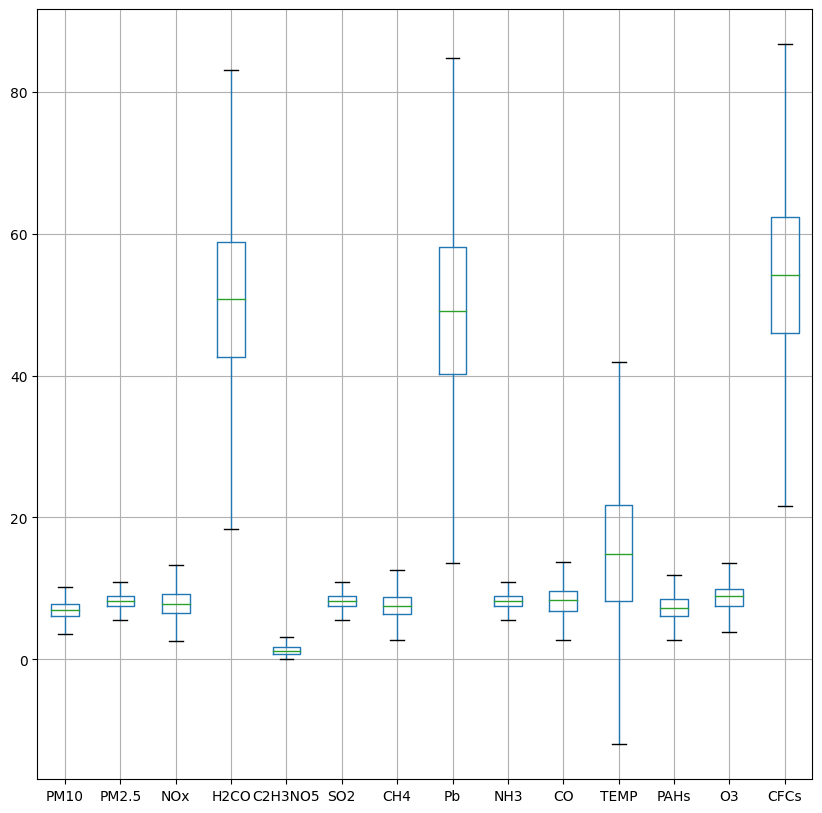

In [36]:
replaced_outliers_data[['PM10', 'PM2.5', 'NOx', 'H2CO', 'C2H3NO5', 'SO2',
       'CH4', 'Pb', 'NH3', 'CO', 'TEMP', 'PAHs', 'O3',
       'CFCs']].boxplot(figsize=(10,10))

In [37]:
merged_data.duplicated().value_counts()

False    11994
dtype: int64

Dôkaz, že každý záznam máme opísaný jedným riadkom.

***

# Realizácia predspracovania dát

In [38]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11994 entries, 0 to 25302
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   warning  11994 non-null  float64
 1   PM10     11994 non-null  float64
 2   PM2.5    11994 non-null  float64
 3   NOx      11994 non-null  float64
 4   H2CO     11994 non-null  float64
 5   C2H3NO5  11994 non-null  float64
 6   SO2      11994 non-null  float64
 7   CH4      11994 non-null  float64
 8   Pb       11994 non-null  float64
 9   NH3      11994 non-null  float64
 10  CO       11994 non-null  float64
 11  TEMP     11994 non-null  float64
 12  PAHs     11994 non-null  float64
 13  PRES     11994 non-null  float64
 14  O3       11994 non-null  float64
 15  CFCs     11994 non-null  float64
 16  area     11994 non-null  object 
dtypes: float64(16), object(1)
memory usage: 1.9+ MB


In [39]:
train_data, test_data = train_test_split(merged_data, test_size=0.2, random_state=42)

In [40]:
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (9595, 17)
Test data:  (2399, 17)


## Transformácia pre strojové učenie

array([[<AxesSubplot: title={'center': 'warning'}>,
        <AxesSubplot: title={'center': 'PM10'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'NOx'}>],
       [<AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>],
       [<AxesSubplot: title={'center': 'Pb'}>,
        <AxesSubplot: title={'center': 'NH3'}>,
        <AxesSubplot: title={'center': 'CO'}>,
        <AxesSubplot: title={'center': 'TEMP'}>],
       [<AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CFCs'}>]], dtype=object)

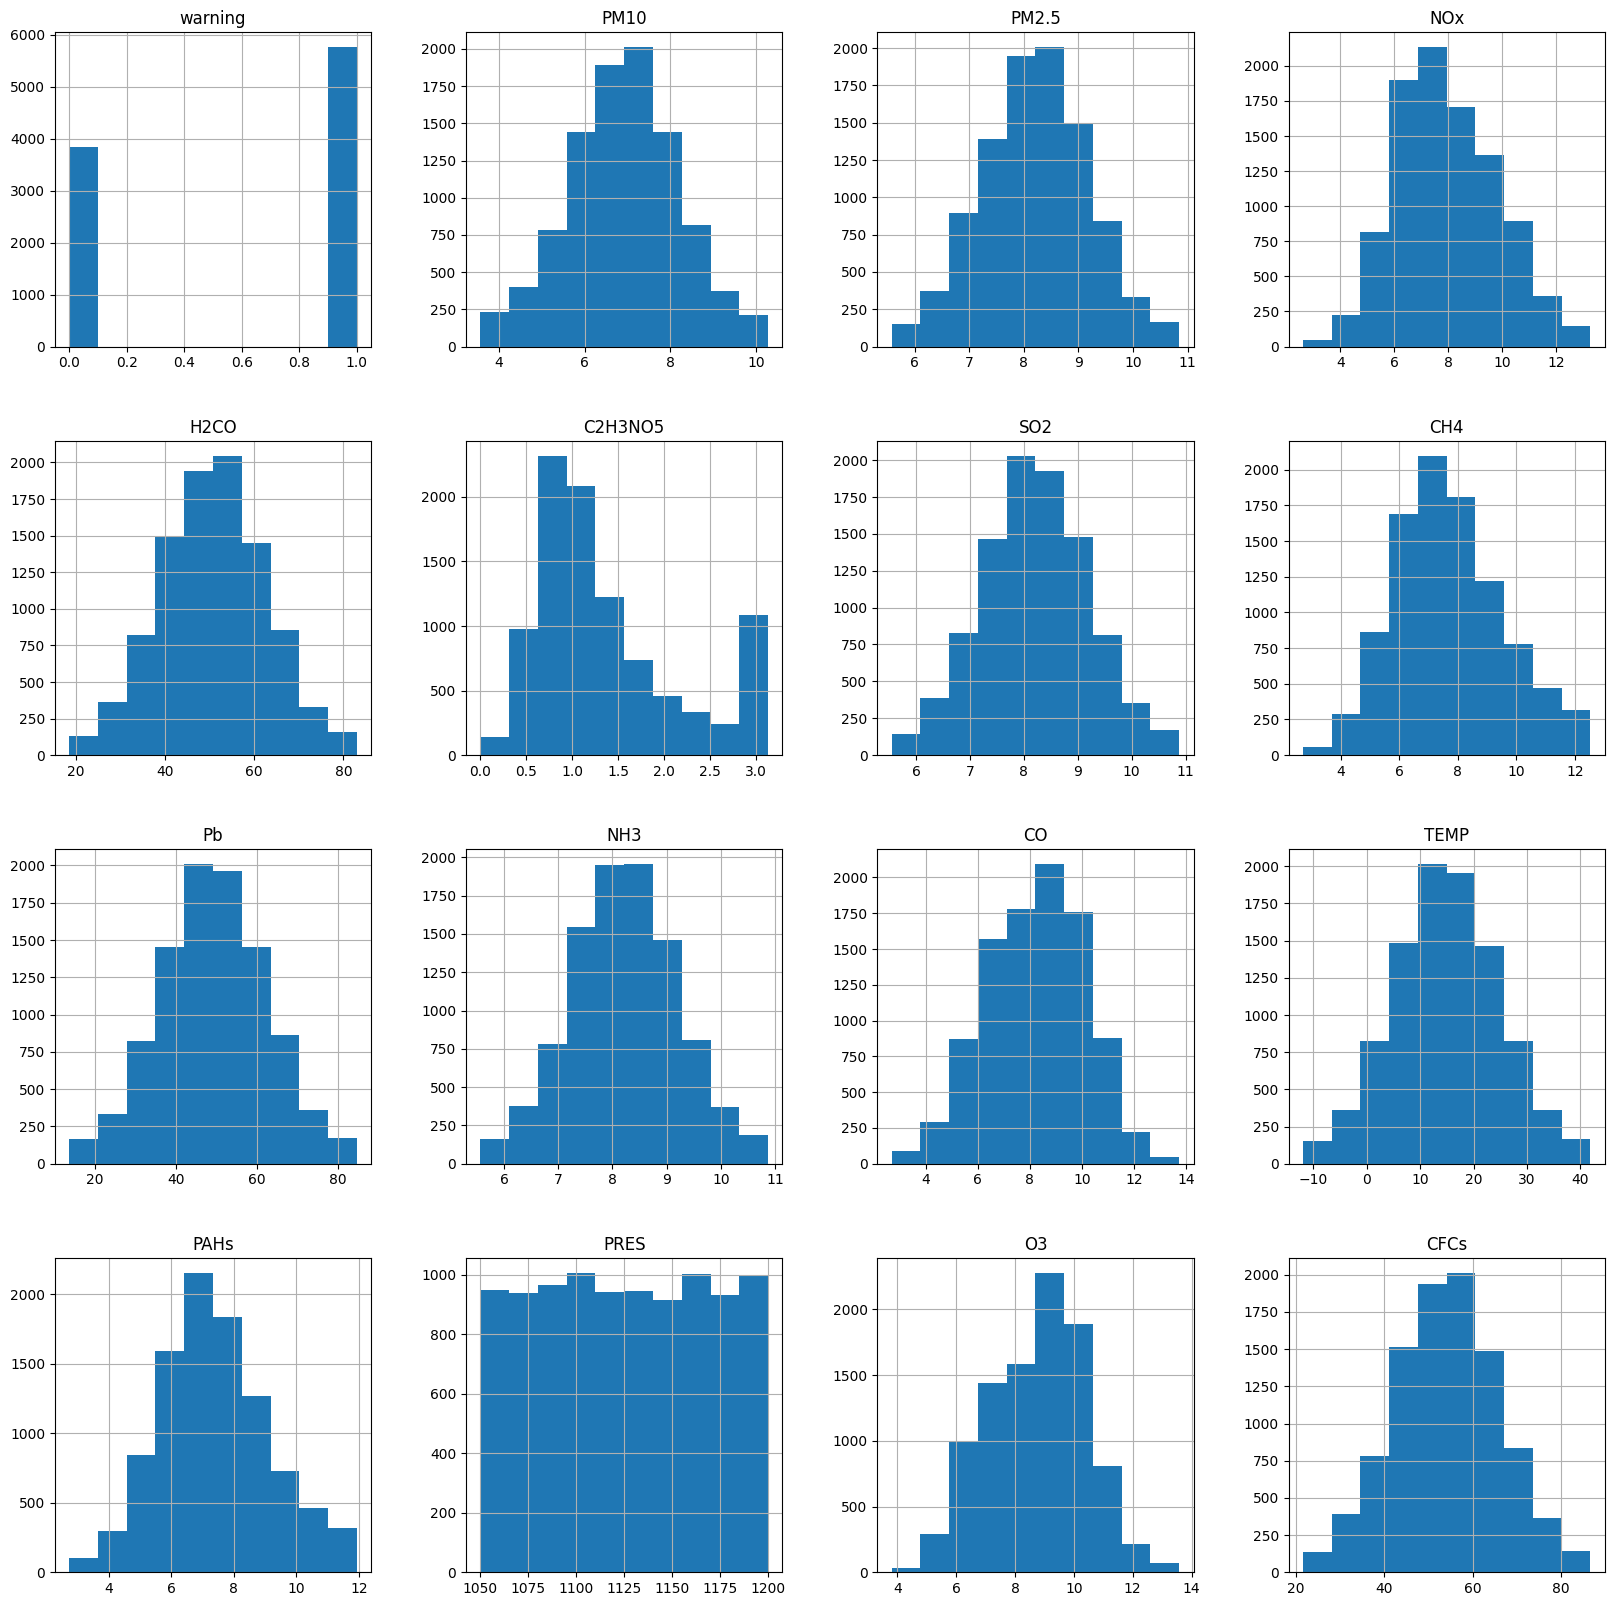

In [41]:
train_data.hist(figsize=(20,20))

In [42]:
numerical=['PM10', 'PM2.5', 'NOx', 'H2CO', 'C2H3NO5', 'SO2','CH4', 'Pb', 'NH3', 'CO', 'TEMP', 'PAHs', 'PRES', 'O3','CFCs']
skewed=['C2H3NO5']
atributes=['area']

Na základe predchádzajúcich histogramov vieme povedať o rozdelení daných dát a dokážeme si ich upraviť do vhodnejšieho tvaru. Dáta si teda rozdelíme do viacerých skupín. Následne na ne aplikujeme jednotlivé funkcie.


### One Hot Encoder

In [43]:
x = ce.OneHotEncoder(cols=atributes)

In [44]:
train_data1 = x.fit_transform(train_data)

C:\Users\filip\.virtualenvs\IAU-Project-FF\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [45]:
train_data1.head()

,warning,PM10,PM2.5,NOx,H2CO,C2H3NO5,SO2,CH4,Pb,NH3,...,PRES,O3,CFCs,area_1,area_2,area_3,area_4,area_5,area_6,area_7
19045,1.0,6.19725,7.12544,7.07276,45.04309,0.658560,6.19391,11.92146,52.95064,10.87173,...,1097.16608,10.68339,37.448690,1,0,0,0,0,0,0
19994,0.0,6.71052,6.41358,11.40696,37.83560,0.717520,6.43993,5.51622,41.83662,7.70566,...,1134.35467,10.26073,57.214240,0,1,0,0,0,0,0
732,1.0,9.21721,7.36392,5.67973,46.58661,3.130144,7.82443,8.67558,68.32600,8.76270,...,1160.84391,7.94217,59.398690,0,0,1,0,0,0,0
11893,1.0,5.95840,7.71042,7.82476,36.25128,0.616160,7.82693,7.40129,34.19528,5.90280,...,1196.68791,5.87293,54.309490,0,0,1,0,0,0,0
22784,0.0,6.33112,9.26379,9.27610,45.11597,1.359320,10.51872,5.63045,23.65298,8.55061,...,1186.50331,10.04748,86.677732,1,0,0,0,0,0,0


Pomocou techniky *One Hot Encoding* sme transformovali názvy krajín do stĺpcov s numerickými hodnotami.

                    1 2 3 4 5 6 7
                    
    **Europe**    - 1 0 0 0 0 0 0

    **America**   - 0 1 0 0 0 0 0 

    **Asia**      - 0 0 1 0 0 0 0

    **Pacific**   - 0 0 0 1 0 0 0

    **Africa**    - 0 0 0 0 1 0 0

    **Australia** - 0 0 0 0 0 1 0

    **Indian**    - 0 0 0 0 0 0 1

Tieto stĺpce reálne nevyužijeme pri strojovom učení, je to iba ukážka danej techniky.

### PowerTransformer &  Quantile Transformer

***Spôsob normalizácie dát*** je, dostať ich do normálneho rozdelenia. V našom datasete sme mali posunuté hodnoty od gaussovej krivky iba v stĺpci 'C2H3NO5'. Preto sa pokúsime tieto dáta dostať čo najbližšie k gaussovej krivke.

In [46]:
train_data_gaus=train_data1.copy()
qt = QuantileTransformer(output_distribution="normal",n_quantiles=1000)
train_data_gaus[skewed] = qt.fit_transform(train_data1[skewed])

array([[<AxesSubplot: title={'center': 'C2H3NO5'}>]], dtype=object)

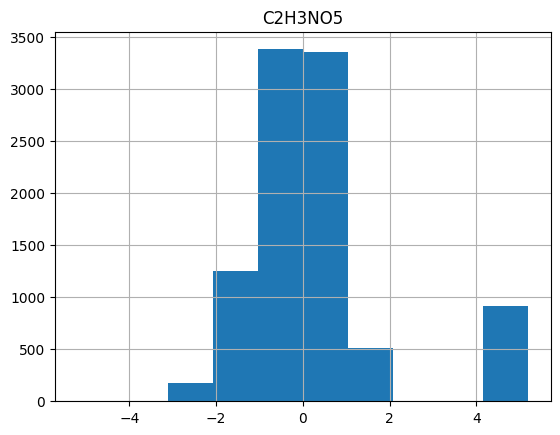

In [47]:
train_data_gaus[skewed].hist()

***

Všetky dáta si upravíme pomocou **PowerTransformer** s metódou yeo-johnson, keďže naše dáta nemajú striktne pozitívne hodnoty. Vďaka tomu sa dáta budú čo najviac približovať ku gausovmu rozdeleniu.

In [48]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True) 

In [49]:
train_data_gaus[numerical] = power_transformer.fit_transform(train_data_gaus[numerical])

array([[<AxesSubplot: title={'center': 'PM10'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'NOx'}>,
        <AxesSubplot: title={'center': 'H2CO'}>],
       [<AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>,
        <AxesSubplot: title={'center': 'Pb'}>],
       [<AxesSubplot: title={'center': 'NH3'}>,
        <AxesSubplot: title={'center': 'CO'}>,
        <AxesSubplot: title={'center': 'TEMP'}>,
        <AxesSubplot: title={'center': 'PAHs'}>],
       [<AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CFCs'}>, <AxesSubplot: >]],
      dtype=object)

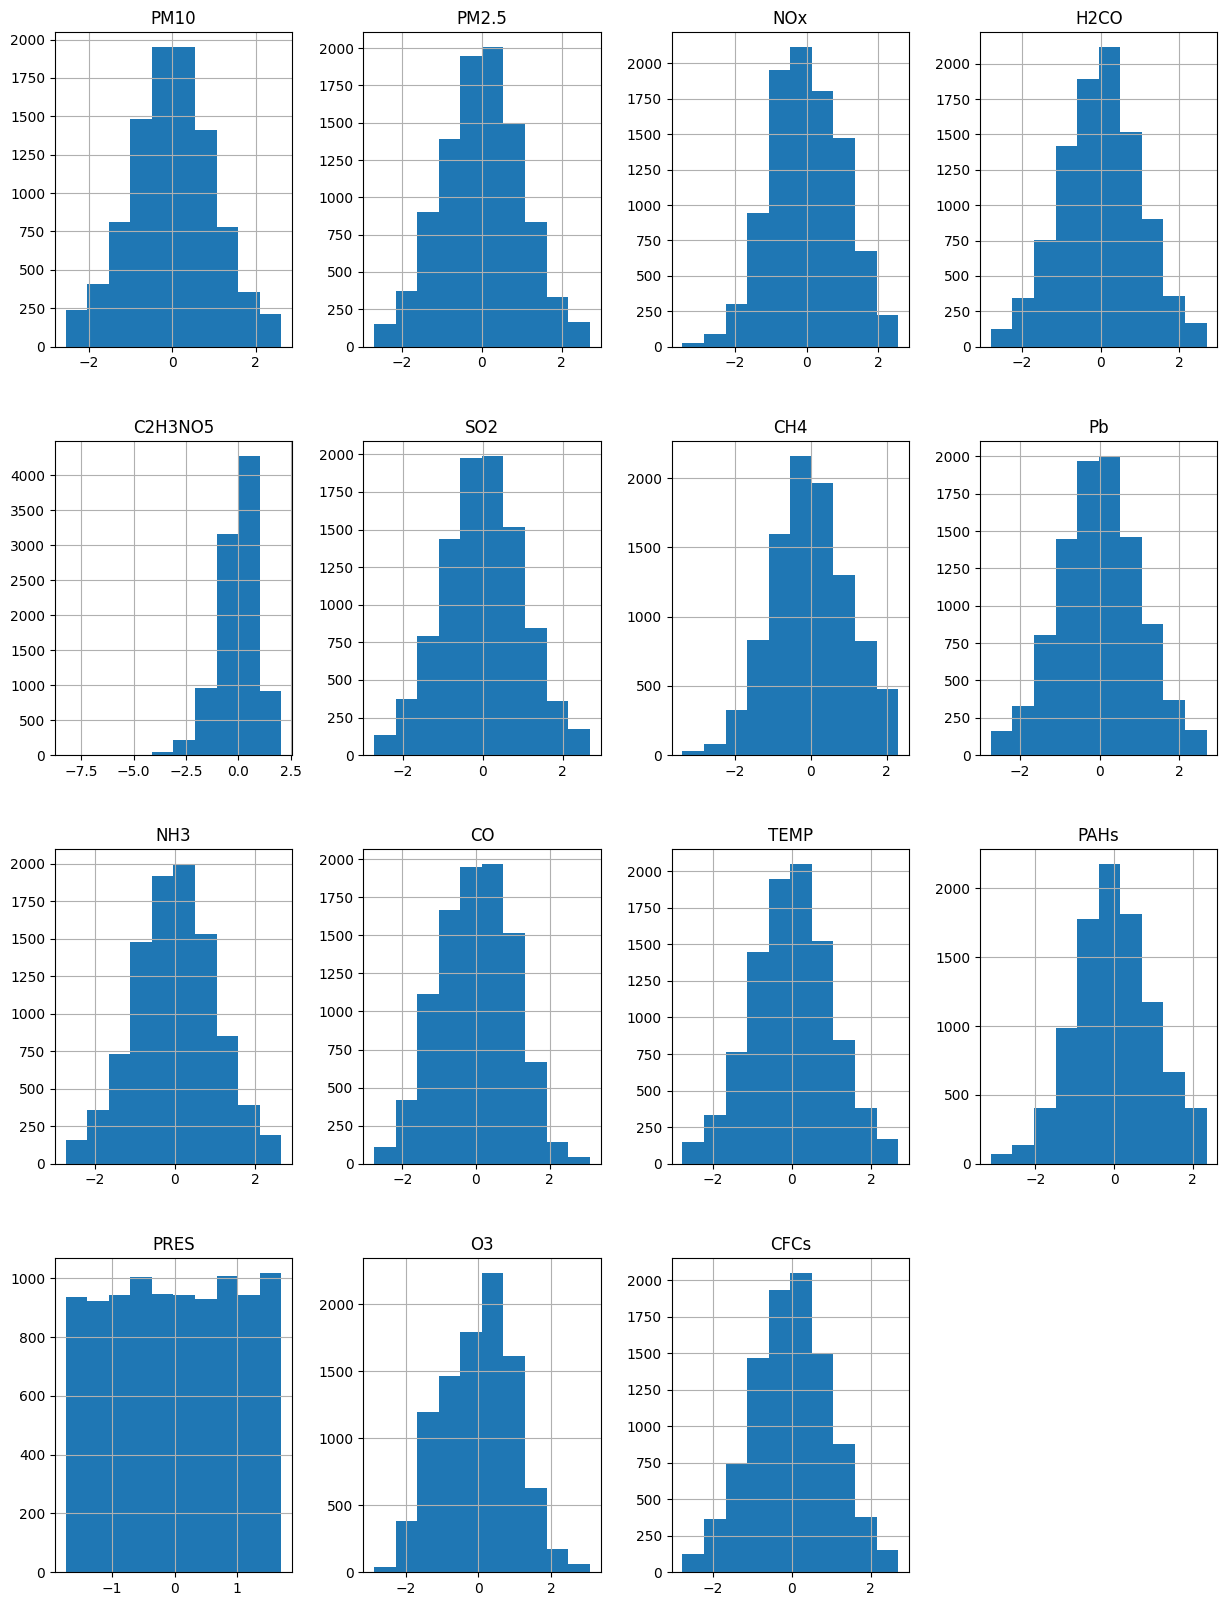

In [50]:
train_data_gaus[numerical].hist(figsize = (15,20))

### Standard Scaler

***Spôsob škálovania dát*** nám dáta transformuje na distribúciu, ktorá má mean=0 a štandardnú odchýlku=1. Tento spôsob je výhodný keď máme v dátach významných outlierov.

In [51]:
standard_scaler = StandardScaler()

In [52]:
train_data_standard=train_data1.copy()
train_data_standard[numerical] = standard_scaler.fit_transform(train_data1[numerical]) 

array([[<AxesSubplot: title={'center': 'PM10'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'NOx'}>,
        <AxesSubplot: title={'center': 'H2CO'}>],
       [<AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>,
        <AxesSubplot: title={'center': 'Pb'}>],
       [<AxesSubplot: title={'center': 'NH3'}>,
        <AxesSubplot: title={'center': 'CO'}>,
        <AxesSubplot: title={'center': 'TEMP'}>,
        <AxesSubplot: title={'center': 'PAHs'}>],
       [<AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CFCs'}>, <AxesSubplot: >]],
      dtype=object)

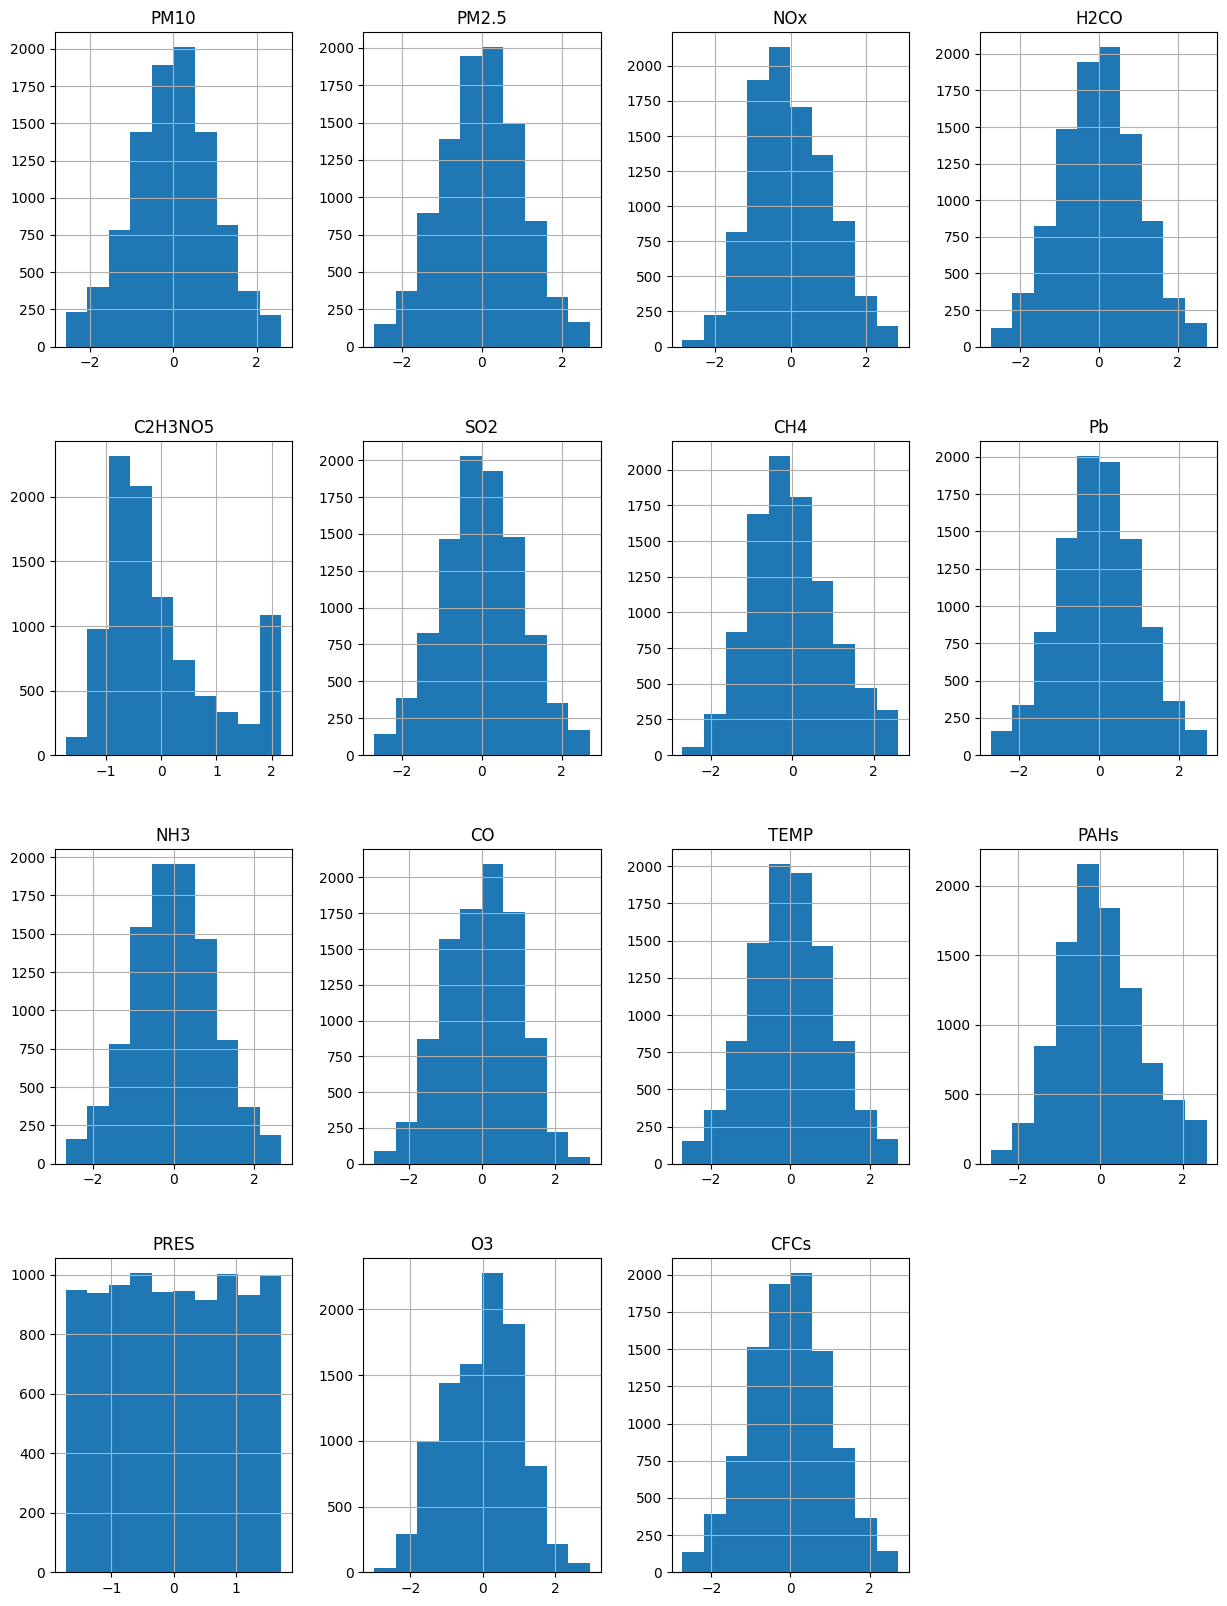

In [53]:
train_data_standard[numerical].hist(figsize = (15,20))

***

Na transformáciu dát sme použili 3 dostupné techniky. 
    
    - One Hot Encoder na kategorické dáta.
    
    - Power Transformer a Quantile Transformer na upravenie dát na normálne rozdelenie.
    - Standard Scaler na škálovanie dát.
    
V ďalšej časti projektu uvidíme, ktoré z posledných 2 techník použijeme.

# Výber atribútov pre strojové učenie

Po úpravách dát si vyberieme tie, ktoré najlepšie korelujú s našou premennou warning a budeme s nimi pracovať. 

Stĺpec s názvom 'area' v strojovom učení používať nebudeme.

    Ukážka ako korelovali dáta pred úpravou.

In [54]:
warning_corr = abs(merged_data.corr()["warning"])
warning_corr.sort_values(ascending=False)

C:\Users\filip\AppData\Local\Temp\ipykernel_24484\2259833399.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  warning_corr = abs(merged_data.corr()["warning"])


warning    1.000000
NOx        0.650920
O3         0.355918
PAHs       0.334227
CH4        0.332549
CFCs       0.021382
PM10       0.017269
H2CO       0.013896
NH3        0.012844
PRES       0.010736
PM2.5      0.009060
SO2        0.008271
CO         0.005902
TEMP       0.005894
Pb         0.005477
C2H3NO5    0.002902
Name: warning, dtype: float64

    Ukážka ako korelovali dáta po úprave.

In [55]:
warning_corr = abs(train_data_gaus[['warning']+numerical].corr()["warning"])
warning_corr.sort_values(ascending=False)

warning    1.000000
NOx        0.648838
O3         0.355751
CH4        0.323245
PAHs       0.321828
H2CO       0.023939
PM10       0.021071
C2H3NO5    0.018826
CFCs       0.015891
SO2        0.011620
PM2.5      0.011040
Pb         0.008481
TEMP       0.002758
CO         0.001919
PRES       0.001337
NH3        0.000054
Name: warning, dtype: float64

In [56]:
warning_corr = abs(train_data_standard[['warning']+numerical].corr()["warning"])
warning_corr.sort_values(ascending=False)

warning    1.000000
NOx        0.656575
O3         0.356561
PAHs       0.339808
CH4        0.334492
H2CO       0.024042
PM10       0.021194
CFCs       0.015926
SO2        0.011597
PM2.5      0.011038
C2H3NO5    0.009523
Pb         0.008464
TEMP       0.002722
CO         0.001783
PRES       0.001440
NH3        0.000035
Name: warning, dtype: float64

S premennou warning nám najviac korelujú tieto údaje: 

    - NOx
    - O3
    - CH4
    - PAHs
    
Vyskúšame si aj ďalšiu techniku určovania významných atribútov.

In [57]:
train_data_select_from_model=train_data_gaus.copy()

In [58]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(
    train_data_select_from_model[numerical], train_data_select_from_model['warning'])
print(selector.estimator_.coef_)
print(selector.get_support())
print(selector.threshold_)

feature_idx = selector.get_support()
feature_name = train_data_select_from_model[numerical].columns[feature_idx]
print(feature_name)

X_new = selector.transform(train_data_select_from_model[numerical])
print(X_new.shape)
X_new
select_out_df = pd.DataFrame(X_new)
select_out_df.head()

[[ 0.55964976 -0.00648223 -2.33848368  0.06232602 -0.10778804  0.04168374
   1.29646792 -0.03534451 -0.01273879 -0.22738547  0.02981878 -0.20040914
  -0.04250035 -0.93421646  0.00859693]]
[ True False  True False False False  True False False False False False
 False  True False]
0.3935927876590328
Index(['PM10', 'NOx', 'CH4', 'O3'], dtype='object')
(9595, 4)


,0,1,2,3
0,-0.562965,-0.430654,2.052171,1.193377
1,-0.166473,1.742658,-1.219233,0.927911
2,1.785640,-1.254658,0.573190,-0.495629
3,-0.747048,-0.016435,-0.095929,-1.712351
4,-0.459671,0.734162,-1.145564,0.794632


Vidíme, že funkcia *Select From Model* nám určila významnosť týchto atribútov:
    
    - PM10
    - NOx
    - CH4
    - O3

Atrbúty sú rovnaké ako aj pri určovaní pomocou korelácie. Preto sme sa rozhodli, že pre učenie nášho modelu pomocou strojového učenia budeme používať TOP 6 najviac korelujúcich dát, alebo dáta, ktoré majú $|correlation| > 0.2$ .

# Replikovateľnosť predspracovania

In [59]:
train_data_for_pipeline=train_data[numerical].copy()
# train_data_for_pipeline_df = pd.DataFrame()

In [60]:
quantileTransformer = QuantileTransformer(output_distribution="normal",n_quantiles=1000)

In [61]:
powerTransformer = PowerTransformer(method='yeo-johnson', standardize=True) 


In [62]:
preprocessing_ppl1 = ColumnTransformer(
    transformers=[
    ("qt", quantileTransformer, skewed),
    ("pt", powerTransformer, numerical)
])

In [63]:
pipeline = Pipeline([
    ("comlete", preprocessing_ppl1)
])

In [64]:
pipeline_out = pipeline.fit_transform(train_data_for_pipeline)
pipeline_out

array([[-1.10140668, -0.56296504, -1.1091149 , ..., -0.64382915,
         1.19337714, -1.40923889],
       [-0.92370707, -0.16647304, -1.83634701, ...,  0.21612737,
         0.92791063,  0.25579725],
       [ 5.19933758,  1.78564037, -0.86540935, ...,  0.82330702,
        -0.49562932,  0.4382714 ],
       ...,
       [-0.61518501, -0.54850265, -1.86236047, ...,  0.51593713,
        -1.30639743, -0.65652224],
       [ 0.64982125,  0.18321838, -0.34817261, ..., -0.10131857,
        -0.43337356, -1.31829784],
       [ 0.11944593, -0.15321192, -0.1027316 , ...,  1.17149463,
         0.52155851,  0.75062808]])

In [65]:
pipeline_out_df = pd.DataFrame(pipeline_out)
pipeline_out_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.101407,-0.562965,-1.109115,-0.430654,-0.482315,-1.050700,-2.059156,2.052171,0.279082,2.650052,-0.001477,-0.751954,-0.786684,-0.643829,1.193377,-1.409239
1,-0.923707,-0.166473,-1.836347,1.742658,-1.099731,-0.906284,-1.805741,-1.219233,-0.564073,-0.515434,0.303154,1.528355,0.221266,0.216127,0.927911,0.255797
2,5.199338,1.785640,-0.865409,-1.254658,-0.350780,1.713255,-0.390271,0.573190,1.442383,0.552209,0.351035,-0.270060,-0.406726,0.823307,-0.495629,0.438271
3,-1.221913,-0.747048,-0.511253,-0.016435,-1.236222,-1.160244,-0.387730,-0.095929,-1.145166,-2.366795,0.496139,-1.067129,0.319918,1.638075,-1.712351,0.012731
4,0.333843,-0.459671,1.077307,0.734162,-0.476100,0.245842,2.320783,-1.145564,-1.949272,0.338934,1.446757,-0.900913,-0.770673,1.407354,0.794632,2.697514


In [66]:
train_data_gaus.head()

,warning,PM10,PM2.5,NOx,H2CO,C2H3NO5,SO2,CH4,Pb,NH3,...,PRES,O3,CFCs,area_1,area_2,area_3,area_4,area_5,area_6,area_7
19045,1.0,-0.562965,-1.109115,-0.430654,-0.482315,-1.002468,-2.059156,2.052171,0.279082,2.650052,...,-0.643829,1.193377,-1.409239,1,0,0,0,0,0,0
19994,0.0,-0.166473,-1.836347,1.742658,-1.099731,-0.799274,-1.805741,-1.219233,-0.564073,-0.515434,...,0.216127,0.927911,0.255797,0,1,0,0,0,0,0
732,1.0,1.785640,-0.865409,-1.254658,-0.350780,2.039044,-0.390271,0.573190,1.442383,0.552209,...,0.823307,-0.495629,0.438271,0,0,1,0,0,0,0
11893,1.0,-0.747048,-0.511253,-0.016435,-1.236222,-1.146444,-0.387730,-0.095929,-1.145166,-2.366795,...,1.638075,-1.712351,0.012731,0,0,1,0,0,0,0
22784,0.0,-0.459671,1.077307,0.734162,-0.476100,0.292386,2.320783,-1.145564,-1.949272,0.338934,...,1.407354,0.794632,2.697514,1,0,0,0,0,0,0


Tranformované dáta pomocou pipeline majú o jeden stĺpec naviac, je to konkrétne stĺpec 0. 
Tento stĺpec budeme musieť neskôr odstrániť.

# Záver

V 2. časti projektu sme si spolijili datasety a následne ich upravovali. Najskôr sme nahrádzali chýbahúce dáta. Zistili sme, že ak ich nahradíme prostrednými hodnotami, korelácie sa takmer nezmenia. Následne sme si nahradili vyčnievajúce hodnoty hraničnými hodnotami. Dáta sme si rozdelili na testovací a trénovací dataset a následne sme previedli úpravu dát pre strojové učenie pomocou viacerých možností. Taktiež sme si vyhodnotili, pre ktoré dáta bude vhodné robiť strojové učenie

In [67]:
train_data_gaus.to_csv('train_data_gaus.csv')

In [68]:
train_data_standard.to_csv('train_data_standard.csv')

In [69]:
test_data.to_csv('test_data.csv')